[source](https://www.mathworks.com/help/optim/ug/sudoku-puzzles-problem-based.html)

In [ ]:
import numpy as np
import scipy as sp


In [135]:
empty_sudoku = np.array(
   [[0, 0, 1, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 3, 0, 4, 5, 0, 0],
    [6, 0, 0, 7, 0, 0, 1, 0, 0],
    [0, 4, 0, 5, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 8, 0],
    [0, 0, 0, 0, 0, 6, 0, 9, 0],
    [0, 0, 5, 0, 0, 9, 0, 0, 4],
    [0, 0, 8, 2, 0, 1, 0, 0, 0],
    [3, 0, 0, 0, 0, 0, 7, 0, 0]]
)

sample_solution = np.array(
    [[7, 1, 3, 5, 2, 4, 6, 9, 8],
     [5, 2, 9, 6, 1, 8, 3, 4, 7],
     [6, 4, 8, 7, 3, 9,	2, 5, 1],
     [1, 5, 2, 9, 4, 7, 8, 3, 6],
     [8, 3, 6, 1, 5, 2, 9, 7, 4],
     [4, 9, 7, 3, 8, 6, 5, 1, 2],
     [3, 8, 5, 4, 6, 1, 7, 2, 9],
     [9, 6,	1, 2, 7, 5, 4, 8, 3],
     [2, 7, 4, 8, 9, 3, 1, 6, 5]]
)

empty_sample_solution = np.array(
    [[0, 0, 0, 5, 2, 4, 6, 9, 8],
     [5, 2, 0, 6, 1, 8, 3, 4, 7],
     [6, 4, 8, 7, 3, 9,	2, 5, 1],
     [1, 5, 2, 9, 4, 7, 8, 3, 6],
     [8, 3, 6, 1, 5, 2, 9, 7, 4],
     [4, 9, 7, 3, 8, 6, 5, 1, 2],
     [3, 8, 5, 4, 6, 1, 7, 2, 9],
     [9, 6,	1, 2, 7, 5, 4, 8, 3],
     [2, 7, 4, 8, 9, 3, 1, 6, 5]]
)

very_empty_clues = np.zeros((9,9), dtype = int)
very_empty_clues[0,1] = 1



In [136]:
#you can also just turn the matrix into a sparse one in index format, that might be faster
def sudoku_array_to_clues(clue_array):
    clues_inds_rows, clues_inds_cols = np.where(clue_array>0)
    clues_vals = clue_array[clues_inds_rows, clues_inds_cols]
    return clues_inds_rows, clues_inds_cols, clues_vals

sudocu_array_to_clues(empty_sudoku)

def array_to_vector(sudoku_array):
    #turn a sudoku values array into a binary vector
    flat_values = sudoku_array.flatten()
    binary_values = np.zeros((flat_values.shape[0], 9), dtype = int)
    indices = np.arange(flat_values.shape[0], dtype = int)
    binary_values[indices, flat_values-1] = 1
    return binary_values.flatten()

def vector_to_array(binary_solution):
    #turn a binary vector into a soduku values array
    binary_values = binary_solution.reshape((81,9)) #magig numbers are sudoky dims and number of values possible
    _, flat_values = np.where(binary_values)
    sudoku_array = (flat_values+1).reshape(9,9)
    return sudoku_array

bin_sample_solution = array_to_vector(sample_solution)
vector_to_array(bin_sample_solution)
    

array([[7, 1, 3, 5, 2, 4, 6, 9, 8],
       [5, 2, 9, 6, 1, 8, 3, 4, 7],
       [6, 4, 8, 7, 3, 9, 2, 5, 1],
       [1, 5, 2, 9, 4, 7, 8, 3, 6],
       [8, 3, 6, 1, 5, 2, 9, 7, 4],
       [4, 9, 7, 3, 8, 6, 5, 1, 2],
       [3, 8, 5, 4, 6, 1, 7, 2, 9],
       [9, 6, 1, 2, 7, 5, 4, 8, 3],
       [2, 7, 4, 8, 9, 3, 1, 6, 4]])

In [137]:
#these are operatiors that should apply to a 729 long solution vector x
#x 
NCOLS = 9
NROWS = 9
NVALS = 9

def generate_one_value_constr():
    #[1,1,1,1,1,1,1,1,1, 0,0,0,0,0,....]
    #[0,0,0,0,0,0,0,0,0, 1,1,1,1,1,....
    #...
    return np.kron(np.eye(NROWS*NCOLS), np.ones((1,NVALS))) #np.kron(np.eye(2), np.kron(np.eye(2), np.ones((1,4))))

def generate_row_uniq_constr():
    #[1,..,0, 1,..,0, ... 1,... 0,  0,1,..,0, 0, 
    return np.kron(np.eye(NROWS), np.kron(np.ones((1,NCOLS)), np.eye(NVALS))) #

def generate_col_uniq_constr():
    return np.kron(np.ones((1,NROWS)), np.eye(NCOLS*NVALS))

def generate_block_uniq_constr():
    return np.kron(np.eye(3), np.kron(np.ones((1,3)), np.kron(np.eye(3), np.kron( np.ones((1,3)), np.eye(9)))))

def generate_clues_contr(clues_inds_rows, clues_inds_cols, clues_vals):
    #x[i,j,m] = 1
    op = np.zeros((clues_vals.shape[0], NROWS*NCOLS*NVALS))
    indices = np.arange(clues_vals.shape[0])
    op[indices, NVALS*NCOLS*clues_inds_rows + NVALS*clues_inds_cols + clues_vals-1] = 1
    return op



In [151]:
def solve_sudoku_scipy(clue_array):
    
    clues_inds_rows, clues_inds_cols, clues_vals = sudoku_array_to_clues(clue_array)
    
    A_one_val = generate_one_value_constr()
    A_row = generate_row_uniq_constr()
    A_col = generate_col_uniq_constr()
    A_block = generate_block_uniq_constr()
    A_clues = generate_clues_contr(clues_inds_rows, clues_inds_cols, clues_vals)

    A_full = np.vstack([A_one_val, A_row, A_col, A_block, A_clues])

    solution_size = 9*9*9
    c = np.zeros(solution_size, dtype = np.float64)
    integrality = np.ones(solution_size, dtype = int)
    bounds = sp.optimize.Bounds(lb=0, ub=1) #somthing with 0 and 1
    constraints = sp.optimize.LinearConstraint(A_full, lb=1, ub=1) #somthing with A

    return sp.optimize.milp( c,
                            integrality = integrality, bounds = bounds, constraints = constraints)

res = solve_sudoku_scipy(empty_sample_solution)

vector_to_array(res.x)

array([[7, 1, 3, 5, 2, 4, 6, 9, 8],
       [5, 2, 9, 6, 1, 8, 3, 4, 7],
       [6, 4, 8, 7, 3, 9, 2, 5, 1],
       [1, 5, 2, 9, 4, 7, 8, 3, 6],
       [8, 3, 6, 1, 5, 2, 9, 7, 4],
       [4, 9, 7, 3, 8, 6, 5, 1, 2],
       [3, 8, 5, 4, 6, 1, 7, 2, 9],
       [9, 6, 1, 2, 7, 5, 4, 8, 3],
       [2, 7, 4, 8, 9, 3, 1, 6, 5]])

In [152]:
res = solve_sudoku_scipy(empty_sudoku)

vector_to_array(res.x)

array([[7, 3, 1, 8, 6, 5, 9, 4, 2],
       [8, 9, 2, 3, 1, 4, 5, 6, 7],
       [6, 5, 4, 7, 9, 2, 1, 3, 8],
       [9, 4, 6, 5, 8, 3, 2, 7, 1],
       [1, 2, 3, 9, 4, 7, 6, 8, 5],
       [5, 8, 7, 1, 2, 6, 4, 9, 3],
       [2, 7, 5, 6, 3, 9, 8, 1, 4],
       [4, 6, 8, 2, 7, 1, 3, 5, 9],
       [3, 1, 9, 4, 5, 8, 7, 2, 6]])

In [139]:
wrong_bin_sample_solution = bin_sample_solution.copy()
wrong_bin_sample_solution[10] = 1

generate_one_value_constr()@wrong_bin_sample_solution
generate_row_uniq_constr()@wrong_bin_sample_solution
generate_col_uniq_constr()@wrong_bin_sample_solution
generate_block_uniq_constr()@wrong_bin_sample_solution

generate_clues_contr(*sudoku_array_to_clues(very_empty_clues))@bin_sample_solution
generate_clues_contr(*sudoku_array_to_clues(empty_sample_solution))@bin_sample_solution



array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0.])

In [ ]:
generate_row_uniq_constr()@bin_sample_solution

In [77]:
np.kron(np.eye(4), np.kron(np.eye(4), np.ones((1,4))))

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [75]:
np.kron(np.eye(4), np.kron(np.ones((1,2)),  np.eye(2)))

array([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]])

In [53]:
np.kron(np.ones((1,4)), np.eye(2*2))

array([[1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.]])

In [65]:
np.kron(np.ones(1,2), np.kron(np.eye(2), np.kron(np.ones((1,4)), np.eye(2)))

array([[1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1.]])

In [95]:
def block_unicity_const(x):
    blocks = np.zeros((81))
    U = 0
    V = 0
    x_array = x.reshape((9,9,9))
    for u in range(3):
        for v in range(3):
            for k in range(9):
                blocks[27*u+9*v+k] = np.sum(x_array[3*u:3*(u+1), 3*v:3*(v+1), k])
    return blocks



block_unicity_const(bin_sample_solution)
block_unicity_const(wrong_bin_sample_solution)
            

array([1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

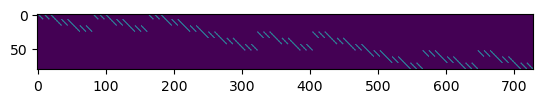

In [97]:
from functools import wraps
import matplotlib.pyplot as plt

def jac_fin_diff(func, h, out_shape = None):
    @wraps(func)
    def wrapper(*args, out_shape=out_shape, **kwargs):
        if out_shape is None:
            out_shape = func(args[0], *args[1:], **kwargs).shape
        N = args[0].shape[0]
        res = np.empty( [N] + list(out_shape)[::-1], dtype = np.float64)
        for i in range(N):
            h_vec = h * np.eye(1, N, k=i).reshape((N,))
            res[i] = ((func(args[0] + h_vec, *args[1:], **kwargs) - func(args[0] - h_vec, *args[1:], **kwargs)) / (2 * h)).T
        return res.T

    return wrapper

plt.imshow(jac_fin_diff(block_unicity_const, h=1)(np.ones_like(bin_sample_solution)))


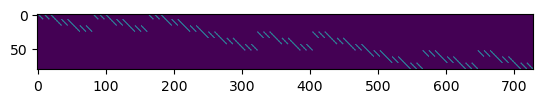

In [105]:
plt.imshow(np.kron(np.eye(3), np.kron(np.ones((1,3)), np.kron(np.eye(3), np.kron( np.ones((1,3)), np.eye(9))))))